# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  

DO 12-17-2018  
Looking at different ethanol ratios

DO 12-19-2018  
Using measured metabolite data to further constrain the system

DO 12-21-2018  
Improved data dashboard  
Fixed the translator dictionaries to force them to use the lowest KEGG ID number for a given metabolite abbreviation  
Fixed some bugs in how the metabolite data gets imported

DO 1-14-2019  
Re-running the analysis using re-processed data from Liang's dataset 2  

DO 1-15-2019  
I moved all of the metabolite processing code to the LT dataset analysis.ipynb file


In [1]:
import numpy as np
from numpy import array, eye, log, zeros
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds, DEFAULT_BOUNDS
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import copy # for copying pp objects
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [2]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations. Choose column names to make it easy to 
    convert the dataframe back to a bounds object
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set pH and ionic strength

In [81]:
# need to declare pH and ionic strength constants at the beginning
# they are used in the make_pathway function
modelFileName = 'cth_thermo_model_DO_SD7.xlsx'
PH = 7.0
IS = 0.1

# load stoichiometric model from Excel file
allRxnDf = pd.read_excel(modelFileName, # using Satya's version
                         sheet_name = 'reactions')

# replace NaN values with 0
allRxnDf.loc[:, 'ppi-pfk':] = allRxnDf.loc[:, 'ppi-pfk':].fillna(0)

# make list of flux sets from excel file column names
# all of the column names from 'ppi-pfk' to 'mal-gapn' inclusive
fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values 

# load bounds information from the model
boundsDf = pd.read_excel(modelFileName, # using Satya's version
                         sheet_name = 'metabolite_bounds')
allRxnDf

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,CBtx,H2O + ATP + Cellobiose_extracellular <=> ADP +...,h2o + atp + cellb_ex <=> adp + pi + cellb,C00001 + C00002 <=> C00008 + C00009,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5,PGMT,Glucose-1-phosphate <=> D-glucose-6-phosphate,g1p <=> g6p,C00103 <=> C00092,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,PGI,D-Glucose-6-phosphate <=> D-Fructose-6-phosphate,g6p <=> f6p,C00092 <=> C00085,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,PFK-PPi,PPi + D-fructose-6-phosphate <=> Phosphate + D...,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,NaN,2,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
8,PFK-ATP,ATP + D-Fructose-6-phosphate <=> ADP + D-Fruct...,atp + f6p <=> adp + fdp,C00002 + C00085 <=> C00008 + C00354,NaN,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,FBA,"D-Fructose-1,6-bisphosphate <=> Glycerone-phos...",fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [5]:
def make_pathway(fluxSet, allRxnDf):
    """
    Given a fluxSet name, return the parsed pathway object
    
    Args:
       fluxSet: is the name of a column in the Excel model file
       allRxnDf: a dataframe with the model reactions
    """
    # choose a flux set, and drop all of the zero-flux reactions
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
                                                                     # processing
    #selectedRxnDf
    # parse the KeggFormula column to create eQuilibrator Reaction objects
    # create reaction list
    reactions = []
    for i, row in selectedRxnDf.iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))

    # create flux list
    fluxes = selectedRxnDf['flux'].values

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)

    # set up the model
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes, 
                 pH = PH, ionic_strength = IS, bounds = None)
    return pp

## Get measured metabolite data and use it to set bounds
* There are several datasets to choose from. For now, I'm going to focus on dataset 2, which we think is the highest quality.
* Note that the originaly analysis Josh did was based on dataset 1, which has more timepoints, but the sampling was done aerobically instead of anaerobically

In [6]:
# get processed metabolite data
metDf = pd.read_excel(r'metabolite_data/lt_dataset2_quantified.xlsx')

# Translate metabolite names to KEGG IDs using KNOWNS csv file
# The plaintext names of the compounds are slightly different from whats in the KEGG_SEED file
# Fortunately, the file also has KEGG IDs
stdsDf = pd.read_csv('metabolite_data/KNOWNS-Dan011419.csv')
stdsDf.set_index('compound', inplace = True)

In [7]:
## looking at particular values for troubleshooting purposes
metDf.loc[metDf['compound'].str.contains('G.P'),:]

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,sample volume ml,ODxml,compound,peakAreaTop,amount,amount_int,KEGG_ID
140,1,A,+EtOH,2,2.016667,1,A1_1,5.00,0.20,10.00,2.0000,GDP,38653.36,0.125860,8.067933,C00035
141,2,A,+EtOH,2,2.016667,2,A1_2,5.00,0.20,10.00,2.0000,GDP,96892.59,0.372059,23.849940,C00035
142,4,A,+EtOH,5,3.750000,2,A2_2,20.00,0.27,7.41,2.0007,GDP,16870.12,0.033774,2.164226,C00035
143,5,A,+EtOH,9,5.916667,1,A3_1,40.00,0.29,6.67,1.9343,GDP,13047.26,0.017613,1.167392,C00035
144,6,A,+EtOH,9,5.916667,2,A3_2,40.00,0.29,6.67,1.9343,GDP,81089.13,0.305252,20.232049,C00035
145,7,B,no EtOH,2,2.016667,1,B1_1,0.20,0.21,10.00,2.1000,GDP,772722.00,1.888176,115.273241,C00035
146,8,B,no EtOH,2,2.016667,2,B1_2,0.20,0.21,10.00,2.1000,GDP,227952.67,0.762400,46.544546,C00035
147,9,B,no EtOH,5,3.750000,1,B2_1,0.47,0.58,3.45,2.0010,GDP,792108.94,1.926145,123.409117,C00035
148,10,B,no EtOH,5,3.750000,2,B2_2,0.47,0.58,3.45,2.0010,GDP,1063253.62,2.457179,157.432757,C00035
149,11,B,no EtOH,9,5.916667,1,B3_1,0.58,1.40,1.11,1.5540,GDP,878805.94,2.095940,172.915225,C00035


In [8]:
# sort the samples in an order that will be useful for subsequent visualization
sampleDf = metDf.loc[:,'ID':'OD'].drop_duplicates()
sampleDf.dropna(axis = 'rows', inplace = True) # drop NaN rows that were added due to ethanol changes
sampleDf.sort_values(['Sample', 'Replicate', 'Timepoint'], inplace = True)

# make new colums
newNames = []
for idx, row in sampleDf.iterrows():
    s = row['Maven filename'] + ' et=' + str(row[' EtOH concentraion (g/L)'])
    #print(s)
    newNames.append(s)
    
sampleDf['graphName'] = newNames    
sampleDf

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,graphName
0,1,A,+EtOH,2,2.016667,1,A1_1,5.00,0.20,A1_1 et=5.0
2,3,A,+EtOH,5,3.750000,1,A2_1,20.00,0.27,A2_1 et=20.0
4,5,A,+EtOH,9,5.916667,1,A3_1,40.00,0.29,A3_1 et=40.0
1,2,A,+EtOH,2,2.016667,2,A1_2,5.00,0.20,A1_2 et=5.0
3,4,A,+EtOH,5,3.750000,2,A2_2,20.00,0.27,A2_2 et=20.0
5,6,A,+EtOH,9,5.916667,2,A3_2,40.00,0.29,A3_2 et=40.0
6,7,B,no EtOH,2,2.016667,1,B1_1,0.20,0.21,B1_1 et=0.2
8,9,B,no EtOH,5,3.750000,1,B2_1,0.47,0.58,B2_1 et=0.47
10,11,B,no EtOH,9,5.916667,1,B3_1,0.58,1.40,B3_1 et=0.58
7,8,B,no EtOH,2,2.016667,2,B1_2,0.20,0.21,B1_2 et=0.2


In [9]:
# convert a bounds object to a dataframe for inspection when troubleshooting
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [27]:
# generate bounds objects for each condition within a dataset
def generate_bounds(metaboliteDf, boundsDf, boundsFromMeasured = [], boundsFromModel = [], 
                    errorFactor = 1):
    """
    Given a dataframe with metabolite values, generate a new bounds object
    for each ID group in the metabolite dataframe
    
    Args:
        metaboliteDf: a dataframe with the following columns
           'ID' - each metabolite group has an ID, and represents a unique combination of Sample, Timepoint and Replicate
           'amount_int' - intracellular metabolite concentration in uM
        boundsDf: a dataframe with the following columns:
           'KEGG_ID'
           'Concantration:Max'
           'Concentration:Min'
        boundsFromMeasured: a list of KEGG IDs to include from measured data (i.e. metabolites whose measurement we trust)
        boundsFromModel: a list of KEGG IDs whose bounds we should get from the cth_thermo_model file
        errorFactor: factor by which upper and lower bounds are adjusted to account for uncertainty
    """
    DEFAULT_LB = 1e-6
    DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
    
    # get default equilibrator-api bounds
    EQ_BOUNDS = Bounds.from_csv_filename('data/cofactors.csv', DEFAULT_LB, DEFAULT_UB) # need to decide if I want to adjust the default bounds to the max and min values from the metabolite dataframe
    
    # get default bounds from model file
    # DO 1-28-2018. It doesn't make sense to re-read the excel file every time I want to get bounds data
    # better to pass the boundsDf dataframe to the function directly
    #boundsDf = pd.read_excel(modelFileName, # using Satya's version
    #                     sheet_name = 'metabolite_bounds')
    boundsDf2 = boundsDf.loc[boundsDf['KEGG_ID'].isin(boundsFromModel)]
   
    boundsList = []
    g = metaboliteDf.groupby('ID') # group the metabolite dataframe by the ID column
    idList = list(g.groups.keys()) # all of the keys in the group
    for name, group in g:
        # set default bounds
        newBounds = EQ_BOUNDS.Copy()
        
        # set bounds based on measured metabolite data
        # these bounds will be modified by the uncertainty factor, excluding ethanol
        # ethanol is excluded because it is measured by HPLC, which is more accurate than LC/MS
        # upper and lower bounds are constrained to default min and max values
        for idx, row in group.iterrows():
            cid = row['KEGG_ID']
            amt = row['amount_int']*1e-6 # amount is in uM, need to convert to M
            if cid in boundsFromMeasured:
                if cid == 'C00469':
                    newBounds.SetBounds(cid, amt, amt) # for ethanol, always use the exact measured concentration
                else:
                    lb = amt/errorFactor
                    ub = amt*errorFactor
                    #print(name, '', cid)
                    
                    # lower bound is outside default range, truncate it 
                    if lb < DEFAULT_LB:    
                        lb = DEFAULT_LB
                        #print(name, '', cid)
                    if lb > DEFAULT_UB:
                        lb = DEFAULT_UB
                        #print(name, '', cid)
                        
                    # if upper bound is outside default range, truncate it    
                    if ub < DEFAULT_LB:
                        ub = DEFAULT_LB
                        #print(name, '', cid)
                    if ub > DEFAULT_UB:
                        ub = DEFAULT_UB
                        #print(name, '', cid)
                        
                    #print('ub=', ub)
                    #print('lb=', lb)
                    newBounds.SetBounds(cid, lb, ub)
        
        # set bounds from model
        # these bounds will overwrite the bounds from metabolite data
        for idx, row in boundsDf2.iterrows():
            cid = row['KEGG_ID']
            lb = row['Concentration:Min']
            ub = row['Concentration:Max']
            newBounds.SetBounds(cid, lb, ub)
        
        boundsList.append(newBounds)
   
    # make a new dataframe with the ID and bounds object for each group
    df = pd.DataFrame({'ID': idList, 'Bounds':boundsList})
    df.set_index('ID', inplace = True)
    return df

In [11]:
def get_model_description(pp, errorFactor = None):
    """
    Given an equilibrator-api pathway object, determine the net reaction 
    and dG0 and format into a string
    """
    rm = ReactionMatcher()
    dG0p = pp.net_reaction().dG0_prime() # float
    rnxTxt = rm.write_text_formula(pp.net_reaction())
    netRxnTxt = '∆G0={0:.2f}\n{1}'.format(dG0p, rnxTxt)
    
    # if an errorFactor is specified, add it to the model description
    if errorFactor:
        netRxnTxt += '\nError factor for measured metabolites: {}'.format(errorFactor)
        
    return netRxnTxt

In [12]:
def calculate_cofactor_ratios(compDf):
    """
    Given a dataframe with concentration values, calculate key cofactor ratios
    Return a dataframe with those ratios
    """

    concDf = compDf.concentration
    serList = []
    serListNames = []

    # calculate ATP/ADP ratio
    if len(concDf.loc[concDf.index.isin(['atp', 'adp'])]) == 2: # make sure both values are present
        atpRatio = concDf.loc['atp']/concDf.loc['adp']
        serList.append(atpRatio)
        serListNames.append('ATP/ADP Ratio')

    # calculate GTP/GDP ratio
    if len(concDf.loc[concDf.index.isin(['gtp', 'gdp'])]) == 2: # make sure both values are present
        gtpRatio = concDf.loc['gtp']/concDf.loc['gdp']
        serList.append(gtpRatio)
        serListNames.append('GTP/GDP Ratio')

    # calculate PPi/Pi ratio
    if len(concDf.loc[concDf.index.isin(['ppi', 'pi'])]) == 2: # make sure both values are present
        ppiRatio = concDf.loc['ppi']/concDf.loc['pi']
        serList.append(ppiRatio)
        serListNames.append('PPi/Pi Ratio')

    # calculate NAD/NADH ratio
    if len(concDf.loc[concDf.index.isin(['nad', 'nadh'])]) == 2: # make sure both values are present
        nadRatio = concDf.loc['nad']/concDf.loc['nadh']
        serList.append(nadRatio)
        serListNames.append('NAD/NADH Ratio')

    # calculate NADP/NADPH ratio
    if len(concDf.loc[concDf.index.isin(['nadp', 'nadph'])]) == 2: # make sure both values are present
        nadpRatio = concDf.loc['nadp']/concDf.loc['nadph']
        serList.append(nadpRatio)
        serListNames.append('NADP/NADPH Ratio')

    # calculate Fd(ox)/Fd(red) ratio
    if len(concDf.loc[concDf.index.isin(['fdxrd', 'fdxox'])]) == 2: # make sure both values are present
        fdxRatio = concDf.loc['fdxox']/concDf.loc['fdxrd']
        serList.append(fdxRatio)
        serListNames.append('Fd(ox)/Fd(red) Ratio')

    df = pd.DataFrame(serList, index = serListNames)
    return df

## Set up plotting

In [13]:
# function for plotting the results
def make_plots(fluxSet,  mdf_values, groupId, compDf, rxnDf, netRxns, 
               savePdf = False, xlabels = [], measuredBounds = [], modelBounds = []):
    """
    Plot the results of the thermodynamic analysis
    Args:
      fluxSet: the name of the set being plotted, also uses this to get the right net reaction info
      mdf_values: list of floats for making the mdf plot
      groupId: x-axis values
      compDf: combined dataframe with compound information
      rxnDf: combined dataframe with reaction information
      netRxns: list of strings that describe each fluxSet
      savePdf: flag for saving the output to a PDF file
      xlabels: list of strings for labeling x-axis
      measuredBounds: list of KEGG IDs of bounds that were specified by measured metabolite data
      modelBounds: list of KEGG IDs of bounds that were specified by the excel model file
    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure( figsize=(20,15))
    fig.suptitle('Analysis of flux set: {}'.format(fluxSet), fontsize=16, )
    plt.figtext(x=0, y=0.95, s=netRxns[fluxSet], fontsize=10, wrap = True)
    gs = GridSpec(6,2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0]) # for MDF plot
    ax2 = fig.add_subplot(gs[1:3, 1]) # rxn shadow price plot
    ax3 = fig.add_subplot(gs[3:, 0]) # metabolite concentrations
    ax4 = fig.add_subplot(gs[3:, 1]) # metabolite shadow prices
    ax5 = fig.add_subplot(gs[1:3, 0]) # dG values
    ax6 = fig.add_subplot(gs[0,1]) # for cofactor ratio plots
    
    # MDF plot
    ax1.plot(groupId.astype(str), mdf_values, 'o')
    ax1.set_title('MDF vs metabolite set')
    ax1.set_ylabel('MDF')
    ax1.set_xlabel('Name')
    if(len(xlabels) >0):
        #ax1.set_xticks(groupId)
        ax1.set_xticklabels(xlabels, rotation = 90)
    ax1.axhline(y=0, color='r', linestyle='--')
    
    # cofactor ratio plot
    df = calculate_cofactor_ratios(compDf)
    sns.heatmap(df, linewidths = 0.05, ax = ax6, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8})
    ax6.set_title('Cofactor Ratios')
    ax6.set_ylabel('Ratio')
    ax6.set_xlabel('Group ID')
    if(len(xlabels) >0):
        ax6.set_xticklabels(xlabels, rotation = 90)
    
    # reaction dG
    dGRange = max(list(map(abs, mdf_values)))
    df = rxnDf.loc[:, 'dGr']
    sns.heatmap(df, linewidths = 0.05, ax = ax5, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8}, vmin=-1*dGRange, vmax=dGRange)
    ax5.set_title('dGr')
    ax5.set_ylabel('Reaction')
    ax5.set_xlabel('Group ID')
    if(len(xlabels) >0):
        ax5.set_xticklabels(xlabels, rotation = 90)
        
    # reaction shadow price plot
    df = rxnDf.loc[:, 'shadow_price']
    sns.heatmap(df, linewidths = 0.05, ax = ax2, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8}, vmin=-1, vmax=1)
    ax2.set_title('Reaction Shadow Price')
    ax2.set_ylabel('Reaction')
    ax2.set_xlabel('Group ID')
    if(len(xlabels) >0):
        ax2.set_xticklabels(xlabels, rotation = 90)
    
    # concentration plot
    df = compDf.loc[:, 'concentration'].apply(np.log10)
    sns.heatmap(df, ax = ax3, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-6, vmax=-2)
    ax3.set_title('Log Concentration')
    ax3.set_ylabel('Metabolite')
    ax3.set_xlabel('Group ID')
    if(len(xlabels) >0):
        ax3.set_xticklabels(xlabels, rotation = 90)

    # metabolite shadow price plot
    df = compDf.loc[:, 'shadow_price'] #.apply(np.log10)
    sns.heatmap(df, ax = ax4, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-2, vmax=2)
    ax4.set_title('Metabolite Shadow Price')
    ax4.set_ylabel('Metabolite')
    ax4.set_xlabel('Group ID')
    if(len(xlabels) >0):
        ax4.set_xticklabels(xlabels, rotation = 90)

        
    # color metabolites by how they were constrained (i.e. default bounds, bounds from measured metabolite data or bounds from model)
    for ax in [ax3, ax4]:
        ytl = ax.get_yticklabels()
        for label in ytl:
            name = label.get_text()
            cid = atkDict[name] # translate metabolite abbreviation to KEGG ID

            # if the bounds come from measured data, change the label color
            if cid in measuredBounds:
                label.set_color('green')

            # if the bounds come from the model, change the label to a different color
            if cid in modelBounds:
                label.set_color('darkorange')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    # save the results as a PDF if that flag is set to True
    if savePdf:
        plt.savefig('metabolite_bounds_{}.pdf'.format(fluxSet), bbox_inches = "tight")
    
    return fig

## Analyze all flux sets

In [26]:
metDf[:5]

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,sample volume ml,ODxml,compound,peakAreaTop,amount,amount_int,KEGG_ID
0,1,A,+EtOH,2,2.016667,1,A1_1,5.0,0.20,10.00,2.0000,3PG,8703433.00,3.400159,217.958918,C00197
1,2,A,+EtOH,2,2.016667,2,A1_2,5.0,0.20,10.00,2.0000,3PG,5454995.00,2.143403,137.397616,C00197
2,3,A,+EtOH,5,3.750000,1,A2_1,20.0,0.27,7.41,2.0007,3PG,746916.06,0.351406,22.518127,C00197
3,4,A,+EtOH,5,3.750000,2,A2_2,20.0,0.27,7.41,2.0007,3PG,1038694.00,0.504024,32.297909,C00197
4,5,A,+EtOH,9,5.916667,1,A3_1,40.0,0.29,6.67,1.9343,3PG,599322.44,0.273058,18.098252,C00197





********* Working on flux set tsac ************
  *** Working on metabolite set 1 ***
  *** Working on metabolite set 3 ***
  *** Working on metabolite set 5 ***
  *** Working on metabolite set 2 ***
  *** Working on metabolite set 4 ***
  *** Working on metabolite set 6 ***
  *** Working on metabolite set 7 ***
  *** Working on metabolite set 9 ***
  *** Working on metabolite set 11 ***
  *** Working on metabolite set 8 ***
  *** Working on metabolite set 10 ***
  *** Working on metabolite set 12 ***


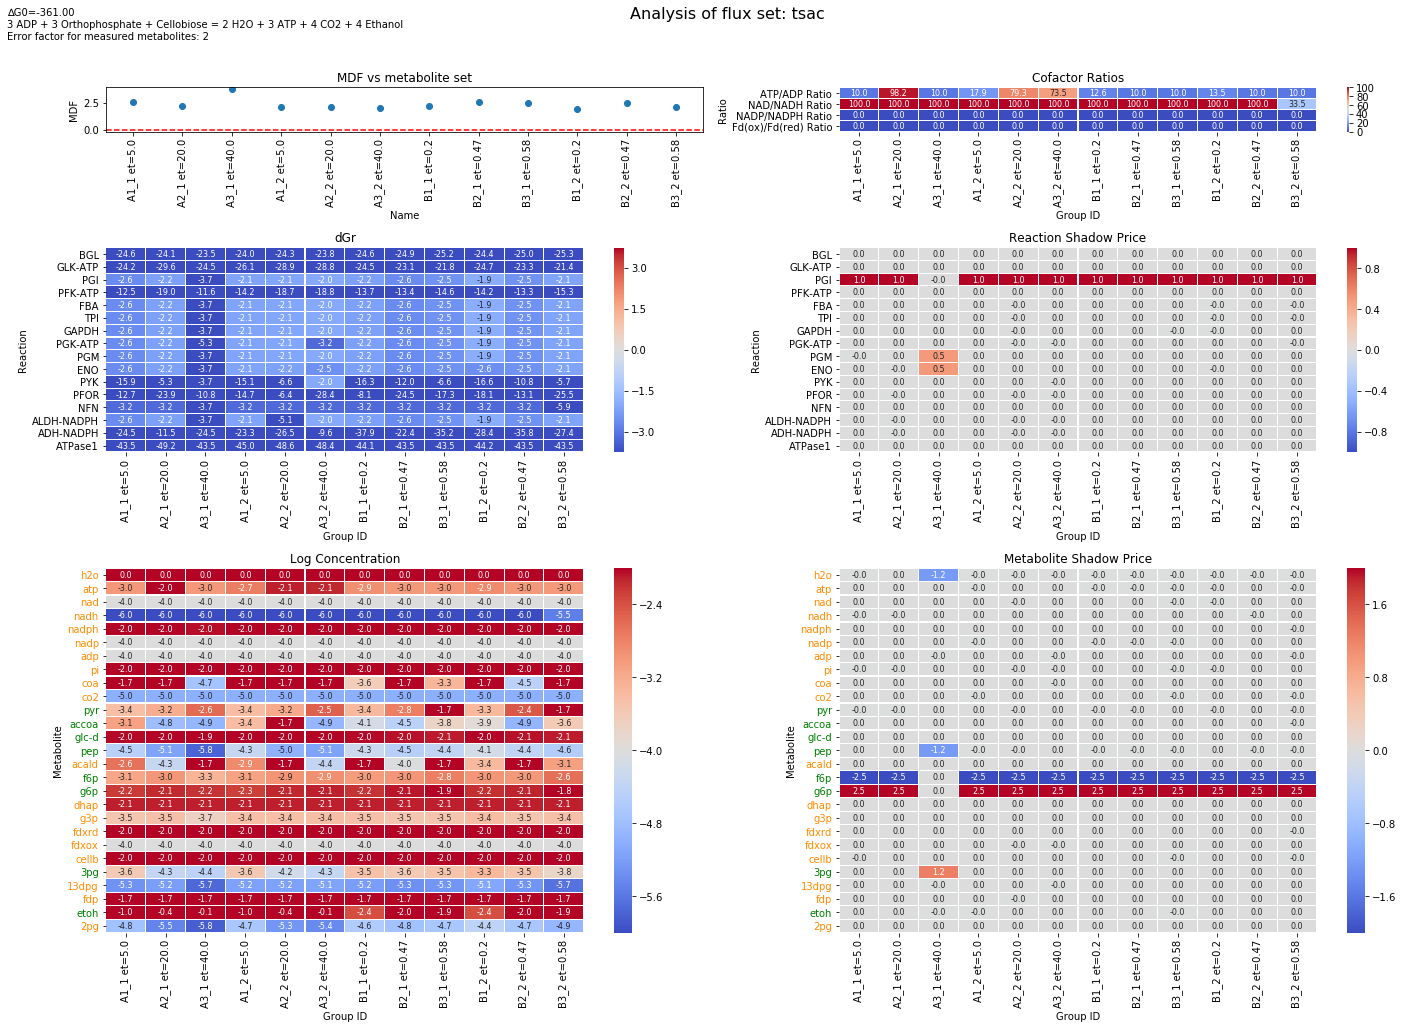

In [80]:
rm = ReactionMatcher() # for translating net reactions to plaintext
fluxSets = ['tsac'] # for testing, when I don't want to run through all of the flux sets
#fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values
netRxns = {} # dictionary to hold net reaction strings for each flux set

# set a custom value for the bounds of one metabolite
# COO354 is FDP
#boundsDf.loc[boundsDf.KEGG_ID == 'C00354', 'Concentration:Max'] = 0.001 # default is 0.02 for FDP
#boundsDf.loc[boundsDf.KEGG_ID == 'C00354', 'Concentration:Min'] = 0.0001 # default is 0.000001 for FDP
# C00111 is DHAP
#boundsDf.loc[boundsDf.KEGG_ID == 'C00111', 'Concentration:Max'] = 0.01 # default is 0.02 for DHAP
#boundsDf.loc[boundsDf.KEGG_ID == 'C00111', 'Concentration:Min'] = 0.001 # default is 0.000001 for DHAP

# make list of bounds to get from metabolite data, label is colored green
#getBoundsFromMeasured = ['C00469'] #boundsDf.loc[boundsDf['GetFromMeasured'].isin(['yes', 'maybe']), 'KEGG_ID'].values
getBoundsFromMeasured = boundsDf.loc[boundsDf['GetFromMeasured'].isin(['yes']), 'KEGG_ID'].values
# make list of bounds to get from model, label is colored orange
getBoundsFromModel = boundsDf.loc[~boundsDf.KEGG_ID.isin(getBoundsFromMeasured), # all non-measured bounds
                                  'KEGG_ID'].values

# set the bounds for each dataset
errorFactor = 2 # set error factor for measured metabolites
allBoundsSets = generate_bounds(metDf, 
                                boundsDf,
                                boundsFromMeasured = getBoundsFromMeasured, 
                                boundsFromModel = getBoundsFromModel,
                                errorFactor = errorFactor,)
allBoundsSets = allBoundsSets.reindex(index = sampleDf.ID.values) # reorder the rows to group replicates together
colNames = sampleDf.graphName.values # labels for x-axis

for fluxSet in fluxSets:
    print('\n\n\n********* Working on flux set {} ************'.format(fluxSet))
    pp = make_pathway(fluxSet, allRxnDf)
    netRxns[fluxSet] = get_model_description(pp, errorFactor)
    
    # calculate the min-max driving force for different ethanol concentrations
    mdf_result = [] # store list of mdf_result objects, in case we want to inspect them later
    mdf_values = [] # store MDF values for making MDF vs. ethanol plot
    compoundDfList = [] # hold report_compounds dataframes
    rxnDfList = [] # hold report_reactions dataframes
    
    for idx, row in allBoundsSets.iterrows():
        print('  *** Working on metabolite set {} ***'.format(idx))
        pp.bounds = row['Bounds']
        result = pp.calc_mdf()
        #result.mdf_plot.show() # show MDF vs. reaction plot
        mdf_result.append(result)
        mdf_values.append(result.mdf)

        # clean up dataframe for compounds
        df = pd.DataFrame(result.report_compounds)
        df['mets'] = df['compound'].map(ktaDict)
        df.set_index('mets', drop = True, inplace = True)
        mi = pd.MultiIndex.from_product([[idx], df.columns], names = ['ID', 'data'])
        df.columns = mi
        compoundDfList.append(df)
        
        # clean up dataframe for reactions
        df2 = pd.DataFrame(result.report_reactions)
        rxnIds = list(r.reaction_id for r in pp.reactions)
        df2['name'] = rxnIds
        df2.set_index('name', drop = True, inplace = True)
        mi2 = pd.MultiIndex.from_product([[idx], df2.columns], names = ['ID', 'data'])
        df2.columns = mi2
        rxnDfList.append(df2)
    
    # merge all of the report_compound dataframes into one big one
    # arrange the compound results in a dataframe to make plotting easy
    compDf = pd.concat(compoundDfList, axis=1)
    compDf = compDf.swaplevel(axis = 'columns')
    
    rxnDf = pd.concat(rxnDfList, axis=1)
    rxnDf = rxnDf.swaplevel(axis = 'columns')

# plot the results
myFig = make_plots(fluxSet, mdf_values, allBoundsSets.index, 
                   compDf, rxnDf, netRxns, savePdf = True, xlabels = colNames, 
                   modelBounds = getBoundsFromModel, measuredBounds = getBoundsFromMeasured)

In [87]:
#myFig.savefig('cth_thermo_with_v6_mets.pdf')

In [53]:
resDf = allBoundsSets.reset_index()
resDf.reset_index(inplace = True)
resDf.set_index('ID', inplace = True)
resDf['colNames'] = colNames
resDf[:5]

,index,Bounds,colNames
ID,,,
1,0,<equilibrator_api.bounds.Bounds object at 0x00...,A1_1 et=5.0
3,1,<equilibrator_api.bounds.Bounds object at 0x00...,A2_1 et=20.0
5,2,<equilibrator_api.bounds.Bounds object at 0x00...,A3_1 et=40.0
2,3,<equilibrator_api.bounds.Bounds object at 0x00...,A1_2 et=5.0
4,4,<equilibrator_api.bounds.Bounds object at 0x00...,A2_2 et=20.0


# visualize metabolite concentrations
* build dataframe with necessary info for 1 mdf result

In [54]:
boundsDf[:5]

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
0,C00008,adp,0.0001,0.000100,Cofactor,no,NaN,100.0,100.0
1,C00020,amp,0.0001,0.000100,Cofactor,no,NaN,100.0,100.0
2,C00002,atp,0.0200,0.001000,Cofactor,no,NaN,20000.0,1000.0
3,C00010,coa,0.0200,0.000001,Cofactor,no,NaN,20000.0,1.0
4,C00139,fdxox,0.0001,0.000100,Cofactor,NaN,NaN,100.0,100.0


In [55]:
# select the mdf object
#experimentID = 3
#mdf = mdf_result[resDf.loc[experimentID]['index']]

def make_conc_plot(experimentID, mdf):
    # given an mdf result, make a concentration plot
    rDf = pd.DataFrame(mdf.report_compounds)
    rDf['abbr'] = rDf['compound'].apply(lambda x: kta.loc[str(x).lower()][0]) # add abbreviations
    rDf.rename({'compound':'KEGG_ID'}, axis=1, inplace = True )

    # get the measured intracellular concentration
    meas = metDf.loc[metDf.ID == experimentID, ['compound', 'amount_int', 'KEGG_ID']]
    m2 = meas.merge(rDf, on = 'KEGG_ID')
    m2['amount_int'] = m2['amount_int']*1e-6 # convert uM to M 

    # get information about whether metabolite was measured or set from the model
    b2 = boundsDf.loc[:,['KEGG_ID', 'GetFromMeasured']]
    m3 = m2.merge(b2, on = 'KEGG_ID')

    # graph the result
    conc_figure, ax = plt.subplots(1,1, figsize = (4,6))
    gfm = m3['GetFromMeasured'] == 'yes'
    m3meas = m3.loc[gfm, :]
    m3model = m3.loc[~gfm, :]
    plt.barh(m3meas.index, width = m3meas['ub'] - m3meas['lb'], height = 0.3, left = m3meas['lb'], align = 'center', alpha = 0.5, color = 'peru', label = 'Concentration range from measured')
    plt.barh(m3model.index, width = m3model['ub'] - m3model['lb'], height = 0.3, left = m3model['lb'], align = 'center', alpha = 0.2, color = 'darkviolet', label = 'Concentration from model')
    plt.xscale('log')
    plt.xlim(5e-7, 1)
    plt.yticks(ticks = m3.index, labels = m2['abbr'])

    plt.plot(m3['concentration'], m3.index, 'bd', markersize = 8, alpha = 0.5, label = 'MDF concentration')
    plt.plot(m3.amount_int, m3.index, 'rd', markersize = 4, alpha = 1, label = 'Measured concentration (M)')
    plt.grid(b = True, which = 'major', axis = 'both', linestyle = '--', color = 'lightgrey', linewidth = '0.3')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    print('Dataset: {},  Name: {}'.format(experimentID, resDf.loc[experimentID]['colNames']))
    plt.show()

Dataset: 1,  Name: A1_1 et=5.0


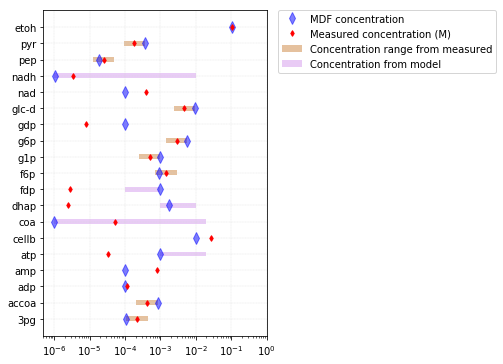

Dataset: 3,  Name: A2_1 et=20.0


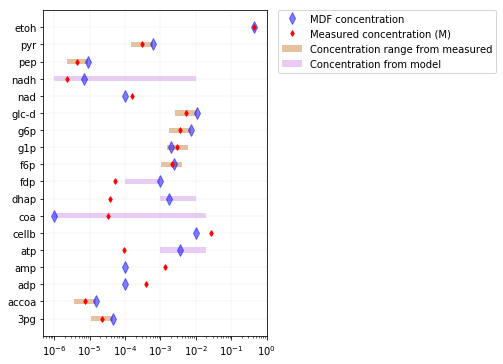

Dataset: 5,  Name: A3_1 et=40.0


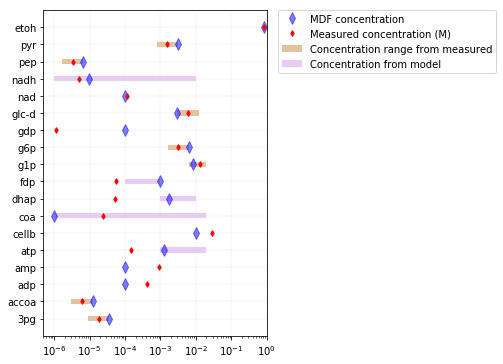

Dataset: 2,  Name: A1_2 et=5.0


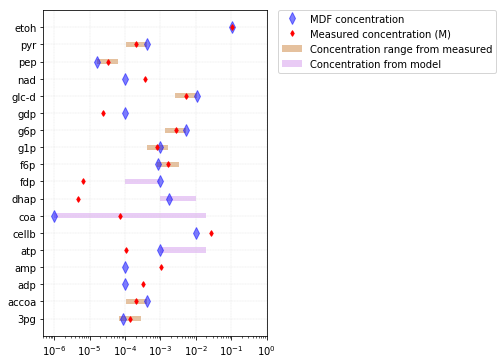

Dataset: 4,  Name: A2_2 et=20.0


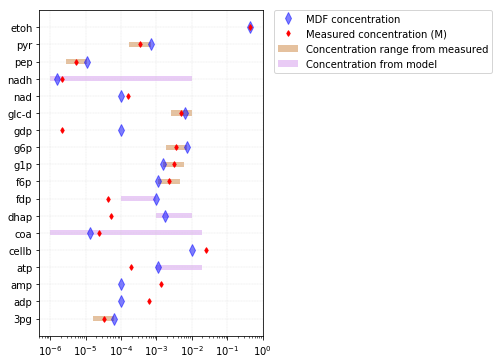

Dataset: 6,  Name: A3_2 et=40.0


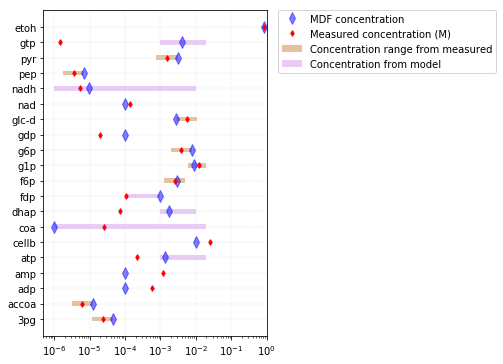

Dataset: 7,  Name: B1_1 et=0.2


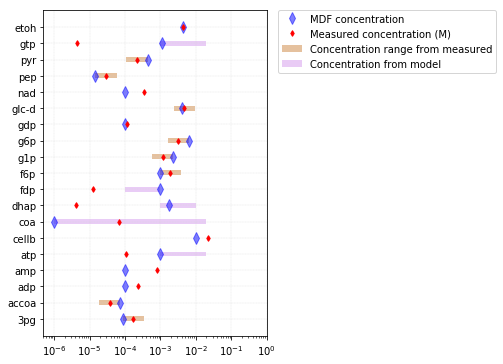

Dataset: 9,  Name: B2_1 et=0.47


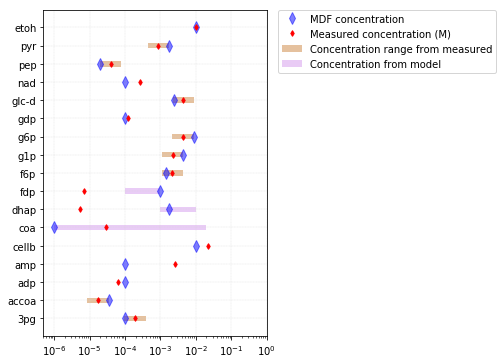

Dataset: 11,  Name: B3_1 et=0.58


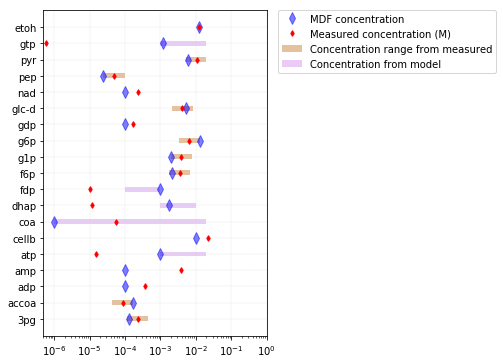

Dataset: 8,  Name: B1_2 et=0.2


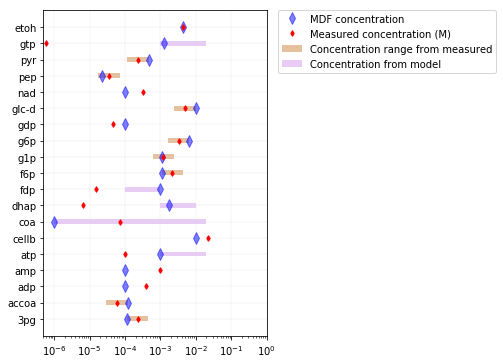

Dataset: 10,  Name: B2_2 et=0.47


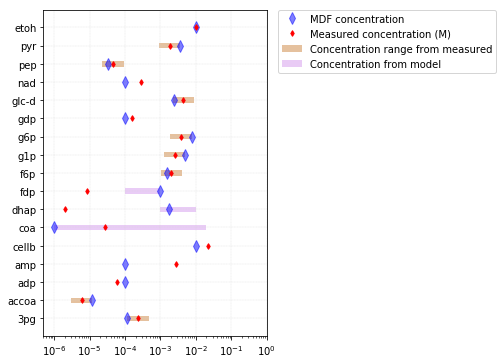

Dataset: 12,  Name: B3_2 et=0.58


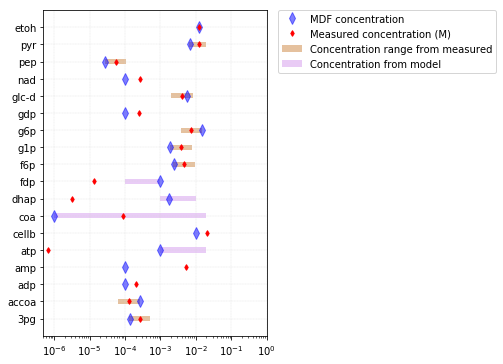

In [56]:
# select the mdf object
for exp in resDf.index:
    #print(exp)
    experimentID = exp
    mdf = mdf_result[resDf.loc[experimentID]['index']]
    make_conc_plot(experimentID, mdf)

In [57]:
# look at bounds
mets = metDf.KEGG_ID.unique()
dfList = []

newCols = {'Compound:Identifiers:kegg.compound':'KEGG_ID', 
           'Concentration:Max': 'max',
           'Concentration:Min': 'min'}

for idx, row in allBoundsSets.iterrows():
    bdf = bounds_to_df(mets, allBoundsSets.loc[idx, 'Bounds'])
    bdf['set'] = idx
    bdf.rename(columns = newCols, inplace = True)
    bdf['min'] = bdf['min'].apply(np.log10)
    bdf['max'] = bdf['max'].apply(np.log10)
    dfList.append(bdf)
    
abDf = pd.concat(dfList)

abDf2 = abDf.set_index(['set', 'KEGG_ID', 'Name']).unstack('set').swaplevel(axis = 1).sort_index(axis =1)

# set display options
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option("display.max_columns",30)
display(abDf2)
pd.reset_option('all')


set             1         2         3         4         5         6        \
               max  min  max  min  max  min  max  min  max  min  max  min   
KEGG_ID Name                                                                
C00002  atp   -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0   
C00003  nad   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0   
C00004  nadh  -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0   
C00005  nadph -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0   
C00006  nadp  -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0   
C00008  adp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0   
C00010  coa   -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0   
C00020  amp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0   
C00022  pyr   -3.4 -4.0 -3.4 -4.0 -3.2 -3.8 -3.2 -3.8 -2.5 -3.1 -2.5 -3.1   
C00024  accoa -3.1 -3.7 -3.4 -4.0 -4.8 -5.4 -1.7 -6.0 -4.9 -5.5 -4.9 -5.5   
C00031  glc-d -2.0 -2.6 -2.0 -2.6 -2.0 -2.6 -2.0 -2.6 -1.9 -2.5 -2.0 -2.6   
C00035  gdp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0   
C00044  gtp   -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0   
C00074  pep   -4.3 -4.9 -4.2 -4.8 -5.0 -5.6 -5.0 -5.6 -5.2 -5.8 -5.1 -5.7   
C00085  f6p   -2.5 -3.1 -2.5 -3.1 -2.4 -3.0 -2.3 -2.9 -1.7 -6.0 -2.3 -2.9   
C00092  g6p   -2.2 -2.8 -2.3 -2.9 -2.1 -2.8 -2.1 -2.7 -2.2 -2.8 -2.1 -2.7   
C00103  g1p   -3.0 -3.6 -2.8 -3.4 -2.2 -2.8 -2.2 -2.8 -1.7 -2.2 -1.7 -2.2   
C00111  dhap  -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0   
C00144  gmp   -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0   
C00149  mal-l -4.1 -4.7 -3.7 -4.3 -3.7 -4.3 -3.7 -4.3 -3.6 -4.2 -3.6 -4.2   
C00185  cellb -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
C00197  3pg   -3.4 -4.0 -3.6 -4.2 -4.3 -4.9 -4.2 -4.8 -4.4 -5.0 -4.3 -4.9   
C00354  fdp   -3.0 -4.0 -3.0 -4.0 -3.0 -4.0 -3.0 -4.0 -3.0 -4.0 -3.0 -4.0   
C00469  etoh  -1.0 -1.0 -1.0 -1.0 -0.4 -0.4 -0.4 -0.4 -0.1 -0.1 -0.1 -0.1   

set             7         8         9         10        11        12       
               max  min  max  min  max  min  max  min  max  min  max  min  
KEGG_ID Name                                                               
C00002  atp   -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0  
C00003  nad   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0  
C00004  nadh  -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0  
C00005  nadph -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0 -2.0 -6.0  
C00006  nadp  -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0  
C00008  adp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0  
C00010  coa   -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0  
C00020  amp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0  
C00022  pyr   -3.4 -4.0 -3.3 -3.9 -2.8 -3.4 -2.4 -3.0 -1.7 -2.3 -1.7 -2.2  
C00024  accoa -4.1 -4.7 -3.9 -4.5 -4.5 -5.1 -4.9 -5.5 -3.8 -4.4 -3.6 -4.2  
C00031  glc-d -2.0 -2.6 -2.0 -2.6 -2.0 -2.7 -2.1 -2.7 -2.1 -2.7 -2.1 -2.7  
C00035  gdp   -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0 -4.0  
C00044  gtp   -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0 -1.7 -3.0  
C00074  pep   -4.2 -4.8 -4.1 -4.7 -4.1 -4.7 -4.0 -4.6 -4.0 -4.6 -4.0 -4.6  
C00085  f6p   -2.4 -3.0 -2.4 -3.0 -2.4 -3.0 -2.4 -3.0 -2.2 -2.8 -2.0 -2.6  
C00092  g6p   -2.2 -2.8 -2.2 -2.8 -2.1 -2.7 -2.1 -2.7 -1.9 -2.5 -1.8 -2.4  
C00103  g1p   -2.6 -3.2 -2.6 -3.2 -2.3 -3.0 -2.3 -2.9 -2.1 -2.7 -2.1 -2.7  
C00111  dhap  -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0 -2.0 -3.0  
C00144  gmp   -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0 -1.7 -6.0  
C00149  mal-l -3.7 -4.3 -3.7 -4.3 -3.5 -4.1 -3.4 -4.0 -2.4 -3.0 -2.4 -3.0  
C00185  cellb -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0  
C00197  3pg   -3.5 -4.1 -3.3 -3.9 -3.4 -4.0 -3.3 -3.9 -3.3 -3.9 -3.3 -3.9  
C00354  fdp   -3.0 -

html.border has been deprecated, use display.html.border instead
(currently both are identical)


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\Dan\Anaconda3\lib\site-packages\pandas\core\config.py:619: FutureWarning: html.border has been deprecated, use display.html.border instead
(currently both are identical)

  warnings.warn(d.msg, FutureWarning)
C:\Users\Dan\Anaconda3\lib\site-packages\pandas\core\config.py:619: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [141]:
bdf['min']

0     0.000174
1     0.000087
2     0.000100
3     0.000100
4     0.001000
5     0.010000
6     0.000001
7     0.000001
8     0.000001
9     0.003078
10    0.002532
11    0.005038
12    0.000100
13    0.002729
14    0.000001
15    0.001394
16    0.000100
17    0.000001
18    0.000100
19    0.000001
20    0.000037
21    0.008357
22    0.001000
23    0.012590
Name: min, dtype: float64

In [80]:
#metDf
metDf.loc[metDf['KEGG_ID'] == 'C06193' ,:]

,ID,Sample,Ethanol,Timepoint,Time (h),Replicate,Maven filename,EtOH concentraion (g/L),OD,sample volume ml,ODxml,compound,peakAreaTop,amount,amount_int,KEGG_ID
163,1,A,+EtOH,2,2.016667,1,A1_1,5.00,0.20,10.00,2.0000,GMP,12965.70,0.109070,6.991688,C06193
164,2,A,+EtOH,2,2.016667,2,A1_2,5.00,0.20,10.00,2.0000,GMP,89730.20,0.937443,60.092487,C06193
165,3,A,+EtOH,5,3.750000,1,A2_1,20.00,0.27,7.41,2.0007,GMP,150765.77,1.423230,91.200803,C06193
166,4,A,+EtOH,5,3.750000,2,A2_2,20.00,0.27,7.41,2.0007,GMP,168009.98,1.554765,99.629526,C06193
167,5,A,+EtOH,9,5.916667,1,A3_1,40.00,0.29,6.67,1.9343,GMP,283028.19,2.432092,161.198699,C06193
168,6,A,+EtOH,9,5.916667,2,A3_2,40.00,0.29,6.67,1.9343,GMP,376959.41,3.148573,208.686990,C06193
169,7,B,no EtOH,2,2.016667,1,B1_1,0.20,0.21,10.00,2.1000,GMP,161795.88,1.507365,92.024733,C06193
170,8,B,no EtOH,2,2.016667,2,B1_2,0.20,0.21,10.00,2.1000,GMP,240237.36,2.105695,128.552817,C06193
171,9,B,no EtOH,5,3.750000,1,B2_1,0.47,0.58,3.45,2.0010,GMP,743206.56,5.988628,383.694560,C06193
172,10,B,no EtOH,5,3.750000,2,B2_2,0.47,0.58,3.45,2.0010,GMP,604650.06,4.885335,313.005990,C06193


In [18]:
# make a table of minimum and maximum metabolite levels
pd.options.display.float_format = '{:,.1f}'.format
piv = pd.pivot_table(metDf,
               values = 'amount_int',
               index = 'compound',
               columns = 'Ethanol',
               aggfunc = ['max', 'min'],
               margins = True
              )
#piv.columns = piv.columns.swaplevel(0,1)
#piv.sort_index(axis=1, level=0, inplace = True)
display(piv)
pd.options.display.float_format = None

max                          min           \
Ethanol                       +EtOH  no EtOH       All     +EtOH  no EtOH   
compound                                                                    
3PG                           218.0    260.9     260.9      18.1    174.0   
ADP                           629.2    394.5     629.2     117.5     58.5   
AMP                         1,352.6  5,136.7   5,136.7     806.6    820.7   
ATP                           217.3    109.1     217.3      34.3      0.7   
Acetyl-CoA                    416.5    130.6     416.5       6.1      6.0   
Cellobiose                 28,081.8 22,740.2  28,081.8  24,486.1 21,140.6   
CoA                            71.6     89.4      89.4      24.3     28.1   
DHAP                           72.0     11.6      72.0       2.5      2.0   
Fructose-1-6-bisphosphate     103.9     15.0     103.9       2.8      7.1   
Fructose-6-phosphate        2,535.2  4,616.3   4,616.3   1,454.5  1,892.4   
GDP                            23.8    244.1     244.1       1.2     46.5   
GMP                           208.7  1,433.7   1,433.7       7.0     92.0   
GTP                             1.4      4.4       4.4       1.4      0.6   
Glucose                     5,962.0  4,913.0   5,962.0   4,719.3  4,093.0   
Glucose-1-phosphate        12,846.0  3,863.5  12,846.0     501.3  1,159.4   
Glucose-6-phosphate         3,934.2  7,556.3   7,556.3   2,696.6  3,199.5   
Malate                        123.6  2,091.1   2,091.1      43.7     98.4   
NAD+                          401.0    340.5     401.0     111.4    233.5   
NADH                            5.2      nan       5.2       2.2      nan   
NADP+                         264.4    111.3     264.4      51.8     87.4   
NADPH                           8.4      0.9       8.4       0.7      0.8   
Phosphoenolpyruvate            32.4     55.1      55.1       3.3     28.9   
Pyruvate                    1,579.3 12,535.1  12,535.1     183.5    220.4   
ethanol                   868,244.0 12,589.5 868,244.0 108,530.5  4,341.2   
All                       868,244.0 22,740.2 868,244.0       0.7      0.6   

                                    
Ethanol                        All  
compound                            
3PG                           18.1  
ADP                           58.5  
AMP                          806.6  
ATP                            0.7  
Acetyl-CoA                     6.0  
Cellobiose                21,140.6  
CoA                           24.3  
DHAP                           2.0  
Fructose-1-6-bisphosphate      2.8  
Fructose-6-phosphate       1,454.5  
GDP                            1.2  
GMP                            7.0  
GTP                            0.6  
Glucose                    4,093.0  
Glucose-1-phosphate          501.3  
Glucose-6-phosphate        2,696.6  
Malate                        43.7  
NAD+                         111.4  
NADH                           2.2  
NADP+                         51.8  
NADPH                          0.7  
Phosphoenolpyruvate            3.3  
Pyruvate                     183.5  
ethanol                    4,341.2  
All                            0.6

# Test metabolites one-by-one for MDF limitations

In [39]:
atkDict['accoa']

'C00024'

In [62]:
#metDf.loc[:,['compound', 'KEGG_ID']].drop_duplicates()
mets_to_test = boundsDf.loc[boundsDf['GetFromMeasured'].isin(['maybe', 'yes']), :].copy()
mets_to_test

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
3,C00010,coa,0.02,0.000001,Cofactor,yes,NaN,20000.0,1.0
14,C00469,etoh,1.00,1.000000,Fixed,yes,NaN,1000000.0,1000000.0
19,C00197,3pg,0.02,0.000001,Intermediate,yes,NaN,20000.0,1.0
21,C00024,accoa,0.02,0.000001,Intermediate,maybe,NaN,20000.0,1.0
23,C00111,dhap,0.02,0.000001,Intermediate,maybe,NaN,20000.0,1.0
24,C00085,f6p,0.02,0.000001,Intermediate,yes,NaN,20000.0,1.0
25,C00354,fdp,0.02,0.000001,Intermediate,maybe,NaN,20000.0,1.0
27,C00092,g6p,0.02,0.000001,Intermediate,yes,NaN,20000.0,1.0
28,C00103,g1p,0.02,0.000001,Intermediate,yes,NaN,20000.0,1.0
29,C00031,glc-d,0.02,0.000001,Intermediate,yes,NaN,20000.0,1.0


In [63]:
#mets_to_test = mets_to_test[mets_to_test.Name == 'accoa'] # for testing a single metabolite

rm = ReactionMatcher() # for translating net reactions to plaintext
fluxSets = ['ppi-pfk'] # this is wt C. therm
netRxns = {} # dictionary to hold net reaction strings for each flux set
mdfSeriesList = [] # empty list to hold MDF data

bs_list = []

for idx, row in mets_to_test.iterrows():
    print('Working on metabolite: {}'.format(row['Name']))
    cid = row['KEGG_ID']
    getBoundsFromMeasured = [cid]
    getBoundsFromModel = boundsDf.loc[~boundsDf.KEGG_ID.isin(getBoundsFromMeasured), # all non-measured bounds
                                  'KEGG_ID'].values
    #print('Measured bounds: {} \nModel bounds: {}'.format(getBoundsFromMeasured, getBoundsFromModel))
    
    # set the bounds for each dataset
    errorFactor = 1 # set error factor for measured metabolites
    allBoundsSets = generate_bounds(metDf, 
                                     boundsFromMeasured = getBoundsFromMeasured, 
                                     boundsFromModel = getBoundsFromModel,
                                     errorFactor = errorFactor)
    bs_list.append(allBoundsSets)
    pp = make_pathway(fluxSets[0], allRxnDf)
    
    # calculate the min-max driving force for different ethanol concentrations
    mdf_values = [] # store MDF values for making MDF vs. ethanol plot
    
    for idx2, row in allBoundsSets.iterrows():
        print('  *** Working on metabolite set {} ***'.format(idx2))
        pp.bounds = row['Bounds']
        result = pp.calc_mdf()
        mdf_values.append(result.mdf)
    
    mdfSeries = pd.Series(mdf_values, index = allBoundsSets.index, name = cid)
    mdfSeriesList.append(mdfSeries)
    
result = pd.DataFrame(mdfSeriesList)

# clean up and add descriptive row and column names
result2 = result.copy()
mtt = mets_to_test.set_index('KEGG_ID')
result2['name'] = mtt['Name']
result2.set_index('name', append = True, inplace = True)
s2 = sampleDf.loc[:, ['ID', 'graphName']]
s2.set_index('ID', inplace = True)
r3 = result2.append(s2.T)
r4 = r3.T
r4.set_index('graphName', append = True, inplace = True)
r5 = r4.T
r5.index = pd.MultiIndex.from_tuples(r5.index)
r5

Working on metabolite: coa
  *** Working on metabolite set 1 ***
  *** Working on metabolite set 2 ***
  *** Working on metabolite set 3 ***
  *** Working on metabolite set 4 ***
  *** Working on metabolite set 5 ***
  *** Working on metabolite set 6 ***
  *** Working on metabolite set 7 ***
  *** Working on metabolite set 8 ***
  *** Working on metabolite set 9 ***
  *** Working on metabolite set 10 ***
  *** Working on metabolite set 11 ***
  *** Working on metabolite set 12 ***
Working on metabolite: etoh
  *** Working on metabolite set 1 ***
  *** Working on metabolite set 2 ***
  *** Working on metabolite set 3 ***
  *** Working on metabolite set 4 ***
  *** Working on metabolite set 5 ***
  *** Working on metabolite set 6 ***
  *** Working on metabolite set 7 ***
  *** Working on metabolite set 8 ***
  *** Working on metabolite set 9 ***
  *** Working on metabolite set 10 ***
  *** Working on metabolite set 11 ***
  *** Working on metabolite set 12 ***
Working on metabolite: 3pg


,ID,1,2,3,4,5,6,7,8,9,10,11,12
,graphName,A1_1 et=5.0,A1_2 et=5.0,A2_1 et=20.0,A2_2 et=20.0,A3_1 et=40.0,A3_2 et=40.0,B1_1 et=0.2,B1_2 et=0.2,B2_1 et=0.47,B2_2 et=0.47,B3_1 et=0.58,B3_2 et=0.58
C00010,coa,2.25832,2.16056,2.40751,2.49589,2.49316,2.47814,2.18364,2.16048,2.43787,2.44993,2.2293,2.092
C00469,etoh,3.47629,3.47629,3.31067,3.31067,2.91662,2.91662,3.47629,3.47629,3.47629,3.47629,3.47629,3.47629
C00197,3pg,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911,2.82911
C00024,accoa,2.28439,2.0725,0.792716,2.82911,0.70978,0.725516,1.45159,1.65572,1.13849,0.701861,1.79836,1.92531
C00111,dhap,-5.47118,-4.7002,-2.16411,-1.75028,-1.71976,-1.32973,-4.83659,-4.30129,-4.55037,-5.77516,-3.59271,-5.22
C00085,f6p,2.66628,2.71238,2.79639,2.82166,2.82911,2.59229,2.75944,2.81155,2.80798,2.78527,1.8035,1.10738
C00354,fdp,-1.00473,-0.492815,0.72472,0.638531,0.75195,1.00953,-0.0913469,0.0250128,-0.434187,-0.321029,-0.221852,-0.0325195
C00092,g6p,2.22901,2.20855,2.29322,2.30016,2.26272,2.32552,2.2615,2.27168,2.35422,2.31903,2.48355,2.52766
C00103,g1p,2.3245,2.45812,2.81647,2.82471,2.82911,2.82911,2.55531,2.56827,2.73607,2.77319,2.82911,2.82911


In [58]:
# look at bounds
b = bs_list[0].loc[1, 'Bounds']
mets = metDf.KEGG_ID.unique()
df = bounds_to_df(mets, b)
df

,Compound:Identifiers:kegg.compound,Name,Concentration:Max,Concentration:Min
0,C00197,3pg,0.020000,0.000001
1,C00024,accoa,0.000417,0.000417
2,C00008,adp,0.000100,0.000100
3,C00020,amp,0.000100,0.000100
4,C00002,atp,0.010000,0.000100
5,C00185,cellb,0.010000,0.010000
6,C00010,coa,0.020000,0.000001
7,C00111,dhap,0.020000,0.000001
8,C00354,fdp,0.020000,0.000001
9,C00085,f6p,0.020000,0.000001


In [ ]:
result

In [110]:
# clean up and add descriptive row and column names
result2 = result.copy()
mtt = mets_to_test.set_index('KEGG_ID')
result2['name'] = mtt['Name']
result2.set_index('name', append = True, inplace = True)
s2 = sampleDf.loc[:, ['ID', 'graphName']]
s2.set_index('ID', inplace = True)
r3 = result2.append(s2.T)
r4 = r3.T
r4.set_index('graphName', append = True, inplace = True)
r5 = r4.T
r5.index = pd.MultiIndex.from_tuples(r5.index)
r5

,ID,1,2,3,4,5,6,7,8,9,10,11,12
,graphName,A1_1 et=5.0,A1_2 et=5.0,A2_1 et=20.0,A2_2 et=20.0,A3_1 et=40.0,A3_2 et=40.0,B1_1 et=0.2,B1_2 et=0.2,B2_1 et=0.47,B2_2 et=0.47,B3_1 et=0.58,B3_2 et=0.58
C00010,coa,2.25832,2.16056,2.40751,2.49589,2.49316,2.47814,2.18364,2.16048,2.43787,2.44993,2.2293,2.092
C00469,etoh,2.74496,2.74496,2.31562,2.31562,2.10095,2.10095,3.47629,3.47629,3.4157,3.4157,3.36359,3.36359
C00197,3pg,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572,2.0572
C00024,accoa,0.553606,0.271079,-1.10893,2.0572,-1.19187,-1.17613,-0.450059,-0.245928,-0.763159,-1.19979,-0.0944353,0.0748304
C00111,dhap,-5.47118,-4.7002,-2.27836,-2.00247,-1.98213,-1.72211,-4.83659,-4.30129,-4.55037,-5.77516,-3.59271,-5.22
C00085,f6p,1.7841,1.8302,1.9142,1.93948,2.0572,1.98076,1.87725,1.92937,1.92579,1.90309,1.8035,1.10738
C00354,fdp,-1.50544,-1.16417,-0.304494,-0.390682,-0.277264,-0.0196868,-0.896521,-0.818947,-1.12508,-1.04964,-0.983524,-0.857302
C00092,g6p,1.4571,1.43664,1.52131,1.52825,1.49081,1.55361,1.48959,1.49977,1.58231,1.54712,1.71164,1.75575
C00103,g1p,1.63836,1.77198,2.0572,2.0572,2.0572,2.0572,1.86917,1.88213,2.04993,2.0572,2.0572,2.0572


In [111]:
#r5.to_excel('single_metabolite_test.xlsx')

In [73]:
#metDf.loc[metDf.KEGG_ID.isin(['C00092', 'C00085']), :].sort_values(['ID', 'compound'])
g6pAmt = metDf.loc[metDf.KEGG_ID == 'C00092', ['ID', 'amount_int']].set_index('ID')
f6pAmt = metDf.loc[metDf.KEGG_ID == 'C00085', ['ID', 'amount_int']].set_index('ID')
#display(f6pAmt)
display(g6pAmt/f6pAmt)

,amount_int
ID,
1,1.980645
2,1.627575
3,1.687356
4,1.606643
5,NaN
6,1.551837
7,1.690701
8,1.508009
9,1.988542
